# Polar alignment

References:

- http://astro.physics.uiowa.edu/~kaaret/2015f_a4850/Lab06_astrometry.html (how RA/DEC tangent projection works)
- http://hosting.astro.cornell.edu/~vassilis/isocont/node17.html FITS and RA/DEC
- https://docs.astropy.org/en/stable/wcs/index.html
- http://www.hnsky.org/astap.htm#astap_command_line
- http://www.hnsky.org/astap_astrometric_solving.htm
- https://github.com/ThemosTsikas/PhotoPolarAlign

In [13]:
from astropy.coordinates import FK5, AltAz
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.wcs import WCS
from astropy.io import fits
from datetime import datetime
from functools import lru_cache
from matplotlib import ticker, cm
import configparser
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os.path as op
import pandas as pd
import scipy.optimize
import subprocess

%matplotlib inline
# %matplotlib notebook  <--- for interactive graphs

## Part 1 - Experiment Setup

Recorded polar alignment session was captured in SharpCap using a 280mm finderscope and ASI 290MM mini. Images have just over 1° horizontal FOV and are pointed within 5° of the North Celestial Pole.

Key | Value
--- | --- 
Observation site | approx. 50.1° North, 14.4° East (Prague, Czech Republic)
Observation time | around 2021-05-31 00:30 GMT+2 (2021-05-30 22:30 GMT)
Telescope | ZWO 60/280 finderscope ([link](https://astronomy-imaging-camera.com/product/finder-and-guider-scope))
Camera | ZWO ASI 290MM mini ([link](https://astronomy-imaging-camera.com/product/asi290mm-mini-mono)), 1936 x 1096 pixels @ 2.9 μm
Mount | iOptron SkyGuider Pro (turned off) w/ iOptron AltAz base, on photo tripod

**Alignment procedure**

1. First image (00003) was taken with the telescope in upright position, pointed approximately at the NCP.
2. The following images (00004 through 00025) are taken with the telescope turned about 90 degrees to the East (ie. to the right, as viewed from behind the telescope). Position of the camera and telescope was fixed with respect to the equatorial mount. Adjustments were made to the AltAz base, according to SharpCap analysis.

In [2]:
lat, lon = 50.1, 14.4
site = EarthLocation.from_geodetic(lon=lon, lat=lat)
arcsec_per_pix = 2.01  # TODO it's best not to rely on this, it's approximate
image_width_pix = 1936
image_height_pix = 1088

def get_image(name: str):
    path = f"./01-captured-images/{name}.png"
    return plt.imread(path)

def get_wcs_header(name: str):
    path = f"./03-astap-analysis/{name}.wcs"
    with open(path, "r", encoding="ascii", errors="ignore") as fp:
        return fits.Header.fromstring(fp.read(), sep='\n')

@lru_cache(maxsize=None)
def get_wcs(name: str):
    return WCS(get_wcs_header(name))

def get_time(name: str) -> datetime:
    path = f"./01-captured-images/{name}.CameraSettings.txt"
    parser = configparser.ConfigParser()
    parser.read(path)
    timestamp_str = parser["ZWO ASI290MM Mini"]["TimeStamp"][:26]
    return datetime.fromisoformat(timestamp_str)

def get_J2000(name: str) -> SkyCoord:
    h = get_wcs_header(name)
    ra, dec = h["CRVAL1"], h["CRVAL2"]
    coord = SkyCoord(ra=ra, dec=dec, frame='fk5', unit="deg", equinox="J2000")
    return coord

def get_altaz(name: str) -> SkyCoord:
    coord = get_J2000(name)
    time = get_time(name)
    altaz_frame = AltAz(obstime=time, location=site)
    return coord.transform_to(altaz_frame)

def get_altaz_deg(name: str) -> np.ndarray:
    coord = get_altaz(name)
    return np.asarray([coord.alt.deg, coord.az.deg])

def get_altaz_frame(name: str) -> AltAz:
    coord = get_J2000(name)
    time = get_time(name)
    altaz_frame = AltAz(obstime=time, location=site)
    return altaz_frame

def J2000_to_pix(reference_name: str, coord: SkyCoord) -> np.ndarray:
    wcs = get_wcs(reference_name)
    return np.asarray(wcs.world_to_pixel(coord))

def pix_to_J2000(reference_name: str, pix: np.ndarray) -> SkyCoord:
    x, y = pix
    wcs = get_wcs(reference_name)
    return wcs.pixel_to_world(x, y)

def J2000_advance_time(coord: SkyCoord, dt_sec: float) -> SkyCoord:
    return SkyCoord(ra=coord.ra.deg - 360/24/60/60 * dt_sec,
                    dec=coord.dec.deg, frame='fk5', unit="deg", equinox="J2000")

def get_image_corners_J2000(name: str):
    return [
        pix_to_J2000(name, (0, 0)),
        pix_to_J2000(name, (image_width_pix, 0)),
        pix_to_J2000(name, (image_width_pix, image_height_pix)),
        pix_to_J2000(name, (0, image_height_pix)),
    ]

all_image_names = [f"_{i:05}" for i in range(3, 26)]
A = all_image_names[0]
B = all_image_names[1]

## Part 2.1 - Algorithm (simple)

- evaluate everything in local coordiantes of image A, this incurs projection error for distances
- use straight J2000 coordinates from ASTAP, no accounting for Earth rotation

In [3]:
# All values "*_pix" are given in A local coordinates (ie. pixels)
output_Ii_J2000 = []
output_Ri_J2000 = []
output_x_errors_arcmin = []
output_y_errors_arcmin = []
output_tot_errors_arcmin = []
output_xy_is_altaz = False

# step (1)
A_J2000 = get_J2000(A)
A_pix = J2000_to_pix(A, A_J2000)

# step (2)
B_J2000 = get_J2000(B)
B_pix = J2000_to_pix(A, B_J2000)

# step (3)
def displacement_error_squared(pix):
    coord = pix_to_J2000(A, pix)
    pix2 = J2000_to_pix(B, coord)
    return np.sum((pix - pix2)**2)

res = scipy.optimize.minimize(displacement_error_squared, A_pix, method="nelder-mead")
R0_pix = res.x
R0_J2000 = pix_to_J2000(A, R0_pix)
print("R_0:", R0_pix, R0_J2000, sep="\n", end="\n\n")

# step (4)
NCP_J2000 = SkyCoord(ra=0, dec=90, frame='fk5', unit="deg", equinox="J2000")
NCP_to_date_J2000 = SkyCoord(ra=0, dec=90, frame='fk5', unit="deg", equinox=get_time(A)).transform_to(FK5(equinox="J2000"))
NCP_to_date_pix = J2000_to_pix(A, NCP_to_date_J2000)

# steps (5), (6)
for I in all_image_names[1:]:
    I_J2000 = get_J2000(I)
    I_pix = J2000_to_pix(A, I_J2000)
    output_Ii_J2000.append(I_J2000)

    offset_pix = I_pix - B_pix  # TODO this is better evaluated in spherical coordinates
    Ri_pix = R0_pix + offset_pix
    Ri_J2000 = pix_to_J2000(A, Ri_pix)
    output_Ri_J2000.append(Ri_J2000)
    
    error_pix = Ri_pix - NCP_to_date_pix
    error_arcmin = error_pix * arcsec_per_pix / 60
    output_x_errors_arcmin.append(error_arcmin[0])
    output_y_errors_arcmin.append(error_arcmin[1])
    output_tot_errors_arcmin.append(np.square(error_arcmin).sum()**0.5)

print("Final error [arcmin]:", output_tot_errors_arcmin[-1])

pd.DataFrame.from_dict(dict(i=all_image_names[1:],
                            Ii_J2000_deg=[[c.ra.deg, c.dec.deg] for c in output_Ii_J2000],
                            Ri_J2000_deg=[[c.ra.deg, c.dec.deg] for c in output_Ri_J2000],
                            tot_error_arcmin=output_tot_errors_arcmin)).set_index("i")

R_0:
[3759.07313474  530.30028833]
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (319.33021342, 86.07620833)>

Final error [arcmin]: 13.540309488338568


,Ii_J2000_deg,Ri_J2000_deg,tot_error_arcmin
i,,,
_00004,"[299.1706166448, 85.43103403922]","[319.3302134194349, 86.0762083265346]",222.076427
_00005,"[278.4054732563, 87.24715123797]","[311.72203929088244, 88.27034476762942]",95.743734
_00006,"[273.2947381873, 87.42023423213]","[308.1119803038066, 88.54683863232313]",80.109499
_00007,"[262.4964971362, 87.67931278654]","[297.13693291113026, 89.02350887187634]",53.774061
_00008,"[242.5464733279, 87.7843324239]","[242.93379467275423, 89.39917523129684]",38.432055
_00009,"[251.961677655, 87.76028953114]","[274.4831701742385, 89.29969308163261]",40.607714
_00010,"[249.9083734349, 87.77824408222]","[268.6896960969255, 89.34467402878852]",38.730164
_00011,"[248.3532505151, 87.79352281884]","[263.94448704073454, 89.37700041625772]",37.441858
_00012,"[249.8396012924, 87.78029923248]","[268.5262595506194, 89.34747454549878]",38.589784


## Part 2.2 - Algorithm (improved)

- evaluate as much as possible in Alt/Az (accounting for Earth rotation, proper measuring of angular distances)
- for $R_0$ computation, compensate Earth rotation as well

In [4]:
# All values "*_pix" are given in A local coordinates (ie. pixels)
output_Ii_altaz_deg = []
output_Ri_altaz_deg = []
output_x_errors_arcmin = []
output_y_errors_arcmin = []
output_tot_errors_arcmin = []
output_xy_is_altaz = True

compensate_AB_time = True  # <--- this should be True for best results

# step (1)
A_J2000 = get_J2000(A)
A_pix = J2000_to_pix(A, A_J2000)
A_time = get_time(A)
A_altaz_frame = get_altaz_frame(A)

# step (2)
B_J2000 = get_J2000(B)
B_pix = J2000_to_pix(A, B_J2000)
B_altaz_frame = get_altaz_frame(B)
B_altaz = get_altaz(B)
B_altaz_deg = get_altaz_deg(B)
B_time = get_time(B)

# step (3)
dt_BA_sec = (B_time - A_time).total_seconds()

def displacement_error_squared_time_comp(pix):
    coord_J2000_A = pix_to_J2000(A, pix)
    
    if compensate_AB_time:
        # What we really want here is to project A(pix) -> Alt/Az -> B(pix2),
        # but platesolving gives us the projection in terms of Ra/Dec J2000.
        # Simply round-tripping through J2000 is not quite correct, since
        # A and B are taken at different times. (Imagine if the mount didn't
        # move at all between A and B - they would have same Alt/Az coordinates,
        # but sightly different J2000.) What we can do is to "fix" the J2000
        # coordinates, baking in the rotation due to time before looking them up in B.
        # Note that we rotate (ie. increment RA) around the CP to date, not the J2000 one.
        coord_to_date_A = coord_J2000_A.transform_to(FK5(equinox=A_time))
        coord_to_date_B = SkyCoord(ra=coord_to_date_A.ra.deg + 360 / 24 / 60 / 60 * dt_BA_sec,
                                   dec=coord_to_date_A.dec.deg,  # ^ approx. 360°/day
                                   frame='fk5', unit="deg", equinox=A_time)
        coord_J2000_B = coord_to_date_B.transform_to(FK5(equinox="J2000"))
    else:
        coord_J2000_B = coord_J2000_A
        
    pix2 = J2000_to_pix(B, coord_J2000_B)
    return np.sum((pix - pix2) ** 2)


res = scipy.optimize.minimize(displacement_error_squared_time_comp, A_pix, method="nelder-mead")
R0_pix = res.x
R0_J2000 = pix_to_J2000(A, R0_pix)
R0_altaz = R0_J2000.transform_to(A_altaz_frame)
R0_altaz_deg = np.asarray([R0_altaz.alt.deg, R0_altaz.az.deg])
print("R_0:", R0_pix, R0_J2000, sep="\n", end="\n\n")

# step (4)
NCP_J2000 = SkyCoord(ra=0, dec=90, frame='fk5', unit="deg", equinox="J2000")
NCP_to_date_J2000 = SkyCoord(ra=0, dec=90, frame='fk5', unit="deg", equinox=get_time(A)).transform_to(
    FK5(equinox="J2000"))
NCP_to_date_pix = J2000_to_pix(A, NCP_to_date_J2000)
NCP_to_date_altaz = NCP_to_date_J2000.transform_to(A_altaz_frame)
NCP_to_date_altaz_deg = np.asarray([NCP_to_date_altaz.alt.deg, NCP_to_date_altaz.az.deg])

# steps (5), (6)
for I in all_image_names[1:]:
    I_time = get_time(I)
    I_J2000 = get_J2000(I)
    I_altaz = get_altaz(I)
    I_altaz_deg = get_altaz_deg(I)
    output_Ii_altaz_deg.append(I_altaz_deg)

    offset_altaz_deg = I_altaz_deg - B_altaz_deg
    Ri_altaz_deg = R0_altaz_deg + offset_altaz_deg
    output_Ri_altaz_deg.append(Ri_altaz_deg)

    p1 = SkyCoord(Ri_altaz_deg[1], Ri_altaz_deg[0], unit="deg")
    p2 = SkyCoord(NCP_to_date_altaz_deg[1], NCP_to_date_altaz_deg[0], unit="deg")
    error_deg = p1.separation(p2).deg
    error_az, error_alt = p2.spherical_offsets_to(p1)

    error_arcmin = error_deg * 60
    output_x_errors_arcmin.append(error_az.deg * 60)
    output_y_errors_arcmin.append(error_alt.deg * 60)
    output_tot_errors_arcmin.append(error_arcmin)

print("Final error [arcmin]:", output_tot_errors_arcmin[-1])

pd.DataFrame.from_dict(dict(i=all_image_names[1:],
                            Ii_altaz_deg=output_Ii_altaz_deg,
                            Ri_altaz_deg=output_Ri_altaz_deg,
                            tot_error_arcmin=output_tot_errors_arcmin)).set_index("i")

R_0:
[3769.70074219  548.70245984]
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (319.20308124, 86.06753404)>

Final error [arcmin]: 1.3909194342762972


,Ii_altaz_deg,Ri_altaz_deg,tot_error_arcmin
i,,,
_00004,"[52.396062964406305, 6.219377188815746]","[50.78320719338648, 5.950750278444111]",230.572194
_00005,"[52.315446235788386, 2.5772159342295025]","[50.70259046476856, 2.3085890238578672]",95.023937
_00006,"[52.321471633582824, 2.0891402563180197]","[50.708615862563, 1.8205133459463845]",78.258687
_00007,"[52.31249301078226, 1.2178156608560609]","[50.69963723976244, 0.9491887504844252]",50.850193
_00008,"[52.37100922752448, 359.91784791582165]","[50.75815345650466, 359.64922100545]",41.913821
_00009,"[52.35651242864686, 0.5115704117294791]","[50.743656657627035, 0.2429435013578436]",39.690012
_00010,"[52.353130572623286, 0.36823812643880366]","[50.74027480160346, 0.09961121606716805]",38.635391
_00011,"[52.346382275004494, 0.2627616630944058]","[50.73352650398467, -0.0058652472772298125]",38.089054
_00012,"[52.352249763682146, 0.3513234261267486]","[50.73939399266232, 0.08269651575511361]",38.531661


## Part 3 - Evaluation

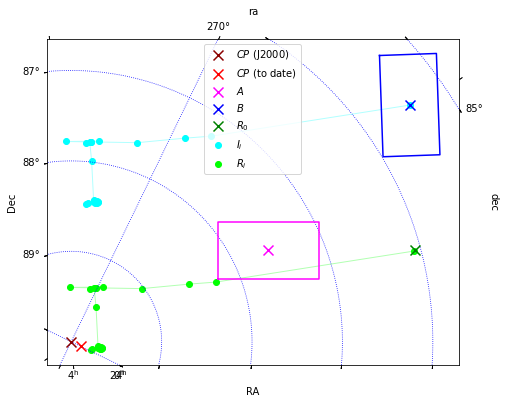

In [14]:
# Note: this view can only visualize "simple" algorithm as it works A local coordinates
# and its associated J2000 transform.

wcs_image = get_wcs(A)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(projection=wcs_image)
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
ax.set_aspect("equal")

def scatter_J2000(coords, **kwargs):
    plt.scatter([c.ra.deg for c in coords],
                [c.dec.deg for c in coords],
                transform=ax.get_transform('icrs'), **kwargs)

def line_J2000(coords, **kwargs):
    line = plt.Line2D([c.ra.deg for c in coords],
                      [c.dec.deg for c in coords],
                      transform=ax.get_transform('icrs'), **kwargs)
    ax.add_line(line)

s = 100
scatter_J2000([NCP_J2000], color="darkred", label="$CP$ (J2000)", marker="x", zorder=3, s=s)
scatter_J2000([NCP_to_date_J2000], color="red", label="$CP$ (to date)", marker="x", zorder=3, s=s)
scatter_J2000([A_J2000], color="magenta", label="$A$", marker="x", zorder=3, s=s)
scatter_J2000([B_J2000], color="blue", label="$B$", marker="x", zorder=3, s=s)
scatter_J2000([R0_J2000], color="green", label="$R_0$", marker="x", zorder=3, s=s)
line_J2000(output_Ii_J2000, color="cyan", linewidth=1, alpha=.3)
line_J2000(output_Ri_J2000, color="lime", linewidth=1, alpha=.3)
scatter_J2000(output_Ii_J2000, color="cyan", label="$I_i$")
scatter_J2000(output_Ri_J2000, color="lime", label="$R_i$")

A_corners_J2000 = get_image_corners_J2000(A)
B_corners_J2000 = get_image_corners_J2000(B)
line_J2000(A_corners_J2000 + [A_corners_J2000[0]], color="magenta")
line_J2000(B_corners_J2000 + [B_corners_J2000[0]], color="blue")

plt.legend()

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='blue', ls='dotted')
#plt.savefig("polar-align-session-overview.svg")

In [6]:
xs = np.linspace(-500, 4500, 50)
ys = np.linspace(-500, 4500, 50)
X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        Z[j, i] = displacement_error_squared((x, y))

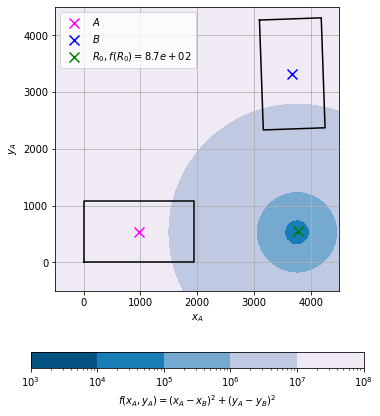

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
plt.xlabel("$x_A$")
plt.ylabel('$y_A$')
ax.set_aspect("equal")

rotation_residual = displacement_error_squared(R0_pix)

s = 100
plt.scatter([A_pix[0]], [A_pix[1]], color="magenta", label="$A$", marker="x", zorder=3, s=s)
plt.scatter([B_pix[0]], [B_pix[1]], color="blue", label="$B$", marker="x", zorder=3, s=s)
plt.scatter([R0_pix[0]], [R0_pix[1]], color="green", label=f"$R_0, f(R_0) = {rotation_residual:.1e}$", marker="x", zorder=3, s=s)

A_corners_J2000 = get_image_corners_J2000(A)
B_corners_J2000 = get_image_corners_J2000(B)
A_corners_pix = [J2000_to_pix(A, coord) for coord in A_corners_J2000]
A_corners_pix.append(A_corners_pix[0])
B_corners_pix = [J2000_to_pix(A, coord) for coord in B_corners_J2000]
B_corners_pix.append(B_corners_pix[0])
ax.add_line(plt.Line2D([x for x, y in A_corners_pix],
                       [y for x, y in A_corners_pix],
                       color="black"))
ax.add_line(plt.Line2D([x for x, y in B_corners_pix],
                       [y for x, y in B_corners_pix],
                       color="black"))

plt.contourf(X, Y, Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
plt.legend()
plt.colorbar(label="$f(x_A, y_A) = (x_A - x_B)^2 + (y_A - y_B)^2$", location="bottom", shrink=.6)
plt.grid()
plt.tight_layout()
#plt.savefig("rotation-solve.svg")

Text(0.5, 1.0, 'Python algorithm (improved, A-B time comp.)')

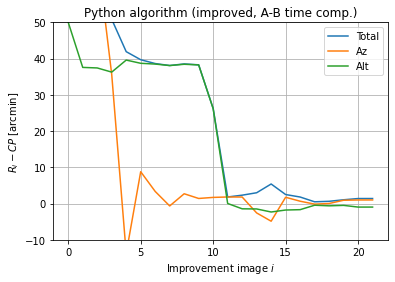

In [16]:
xs = range(len(output_tot_errors_arcmin))

plt.plot(xs, output_tot_errors_arcmin, label="Total")
plt.plot(xs, output_x_errors_arcmin, label="Az" if output_xy_is_altaz else "X (approx. Az)")
plt.plot(xs, output_y_errors_arcmin, label="Alt" if output_xy_is_altaz else "Y (approx. Alt)")
plt.ylim(-10, 50)
#plt.xlim(6,25)
plt.xlabel("Improvement image $i$")
plt.ylabel("$R_i - CP$ [arcmin]")
plt.grid()
plt.legend()
plt.title("Python algorithm (improved, A-B time comp.)")
#plt.savefig("evaluation-python-improved-timecomp.svg")

---

## Appendix: platesolve images with ASTAP

Using *ASTAP version ß0.9.541, 64 bit, dated 2021-5-20* with the H17 star database.

In [9]:
do_platesolve = False

if do_platesolve:
    input_dir = "./01-captured-images"
    output_dir = "./03-astap-analysis"

    for input_image_path in glob.glob(op.join(input_dir, "*.png")):
        name = op.splitext(op.basename(input_image_path))[0]

        args = ["astap",
                "-f", input_image_path,
                "-o", op.join(output_dir, name),
                "-fov", "0.63",  # vetical FOV [deg]
                "-ra", "0.0",  # [h]
                "-dec", "90.0",  # [deg]
                "-annotate"]

        print(" ".join(args))
        subprocess.check_call(args)

astap -f ./01-captured-images/_00024.png -o ./03-astap-analysis/_00024 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captured-images/_00008.png -o ./03-astap-analysis/_00008 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captured-images/_00016.png -o ./03-astap-analysis/_00016 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captured-images/_00017.png -o ./03-astap-analysis/_00017 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captured-images/_00007.png -o ./03-astap-analysis/_00007 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captured-images/_00013.png -o ./03-astap-analysis/_00013 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captured-images/_00020.png -o ./03-astap-analysis/_00020 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captured-images/_00009.png -o ./03-astap-analysis/_00009 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captured-images/_00003.png -o ./03-astap-analysis/_00003 -fov 0.63 -ra 0.0 -dec 90.0 -annotate
astap -f ./01-captu

## Appendix: SharpCap results

In [10]:
sharpcap_location_lat = 50.200
sharpcap_location_lon = 14.920
sharpcap_refraction_correction = False
sharpcap_initial_rotation = 87.7  # [deg]
sharpcap_reported_errors = {
    "_00004": [3, 50, 51, 3, 47, 44,"left", 0,44,34,"down"],
    "_00005": [1,34,27,1,27,4,"left",0,38,7,"down"],
    "_00006": [1,18,8,1,8,24,"left",0,38,28,"down"],
    "_00007": [0,50,49,0,34,40,"left",0,37,27,"down"],
    "_00008": [0,43,10,0,15,13,"right",0,40,26,"down"],
    "_00009": [0,40,27,0,7,42,"left",0,39,45,"down"],
    "_00010": [0,39,33,0,2,12,"left",0,39,30,"down"],
    "_00011": [0,38,57,0,1,49,"right",0,38,57,"down"],
    "_00012": [0,39,24,0,1,33,"left",0,39,24,"down"],
    "_00013": [0,39,11,0,0,10,"left",0,39,13,"down"],
    "_00014": [0,27,17,0,0,56,"left",0,27,15,"down"],
    "_00015": [0,1,37,0,1,11,"left",0,1,5,"down"],
    "_00016": [0,1,13,0,1,10,"left",0,0,19,"up"],
    "_00017": [0,3,11,0,3,10,"right",0,0,20,"up"],
    "_00018": [0,5,35,0,5,25,"right",0,1,20,"up"],
    "_00019": [0,1,30,0,1,25,"left",0,0,31,"up"],
    "_00020": [0,0,34,0,0,4,"left",0,0,34,"up"],
    "_00021": [0,1,6,0,0,46,"right",0,0,47,"down"],
    "_00022": [0,0,45,0,0,38,"right",0,0,22,"down"],
    "_00023": [0,0,42,0,0,16,"left",0,0,38,"down"],
    "_00024": [0,0,19,0,0,18,"left",0,0,2,"up"],
    "_00025": [0,0,21,0,0,19,"left",0,0,8,"down"],
}

In [11]:
def dms_to_deg(deg: int, m: int, s: float) -> float:
    return deg + m/60.0 + s/3600.0

Text(0.5, 1.0, 'SharpCap algorithm')

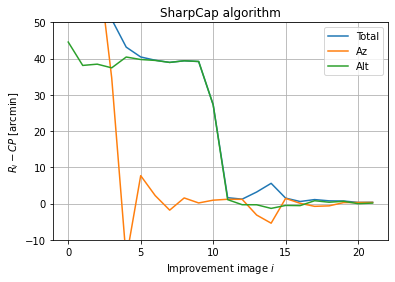

In [17]:
xs = []
ys_total = []
ys_az = []
ys_alt = []

for k, v in sharpcap_reported_errors.items():
    total_error_deg = dms_to_deg(*v[0:3])
    az_error_deg = dms_to_deg(*v[3:6]) * (-1 if v[6] == "right" else 1)
    alt_error_deg = dms_to_deg(*v[7:10]) * -(-1 if v[10] == "down" else 1)
    #print(k, total_error_deg, az_error_deg, alt_error_deg)
    xs.append(k)
    ys_total.append(total_error_deg*60)
    ys_az.append(az_error_deg*60)
    ys_alt.append(alt_error_deg*60)
    
xs = list(range(len(xs)))
plt.plot(xs, ys_total, label="Total")
plt.plot(xs, ys_az, label="Az")
plt.plot(xs, ys_alt, label="Alt")
plt.ylim(-10, 50)
#plt.xlim(6,25)
plt.xlabel("Improvement image $i$")
plt.ylabel("$R_i - CP$ [arcmin]")
plt.grid()
plt.legend()
plt.title("SharpCap algorithm")
#plt.savefig("evaluation-shrapcap.svg")